In [1]:
import math
import random
import socket
import time
from collections import deque, namedtuple
from itertools import count

import matplotlib
import matplotlib.pyplot as plt
import nashpy as nash
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device('cpu')
lr = 1e-1
iters = 500
weight_decay = 1e-3

In [9]:
log = True

In [3]:
class Agent:
    def __init__(self, port: int, i, o, c, rule_sets):
        s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        s.bind(("localhost", port))
        s.listen()
        self.link, _ = s.accept()
        self.input = i
        self.output = o
        self.cache = c
        self.rule_sets = rule_sets
        self.init_output_cache()

    def init_output_cache(self):
        self.output["side"] = -1
        self.output["targetPos"] = {"x":0, "y":0, "z":0}
        self.output["targetVel"] = 0
        self.output["enableFire"] = False
        self.output["formationID"] = 0
        self.output["fireTarget"] = 0
        
        self.cache["fireState"] = False
        self.cache["formation_position_diff"] = {"x":0, "y":0, "z":0}
        self.cache["id_in_formation"] = 0
        self.cache["formationIDPre"] = 0

    def send_output(self):
        px, py, pz = self.output["targetPos"]["x"], self.output["targetPos"]["y"], self.output["targetPos"]["z"]
        side = f'<side><double>{self.output["side"]}</double></side>'
        targetPos = f'<targetPos><c><x><double>{px}</double></x><y><double>{py}</double></y><z><double>{pz}</double></z></c></targetPos>'
        targetVel = f'<targetVel><double>{self.output["targetVel"]}</double></targetVel>'
        enableFire = f'<enableFire><bool>{1 if self.output["enableFire"] else 0}<bool></enableFire>'
        formationID = f'<formationID><uint64_t>{int(self.output["formationID"])}</uint64_t></formationID>'
        fireTarget = f'<fireTarget><uint64_t>{int(self.output["fireTarget"])}</uint64_t></fireTarget>'
        s = '<c>' + targetPos + targetVel + enableFire + formationID + fireTarget + '</c>'
        self.send(s)

    def recv_input(self):
        s = self.recv()
        tmp = []
        for input in eval(s):
            for k, v in input:
                if k == 'carInfo':
                    tmp.append(v)
                else:
                    self.input[k] = v
        self.input['carInfo'] = tmp

    def send(self, s: str):
        if log:
            print(f'send: {s}')
        self.link.send(s.encode() + b'\n')

    def recv(self)->str:
        """will return string ends with '\\n'"""
        s: bytes = b''
        while not s.endswith(b'\n'):
            s = s + self.link.recv(1024)
        if log:
            print(f'received: {s.decode()}')
        return s.decode()
    
    def tick(self):
        # TODO:
        self.rule_sets[0].tick()
        self.rule_sets[0]
        for i in range(1, len(self.rule_sets)):
            self.rule_sets[i].tick()

    def choose_action(self):
        pass

In [4]:
a = Agent(50023, {}, {}, {}, [])

In [8]:
a.recv_input()

In [7]:
a.send_output()

In [19]:
a.input

{'carInfo': []}

In [ ]:
a.output["tar"]

In [ ]:
class Env:
    def __init__(self, port1, port2):
        self.agent1 = Agent(port1)
        self.agent2 = Agent(port2)
        self.agent1.recv_input()
        self.agent2.recv_input()

    def restart(self):
        self.agent1.send('<c><restart><bool>1</bool></restart></c>')
        self.agent2.send('<c><restart><bool>1</bool></restart></c>')
        self.agent1.recv_input()
        self.agent2.recv_input()

    def start(self):
        self.step()

    def step(self):
        self.agent1.send_output()
        self.agent2.send_output()
        self.agent1.recv_input()
        self.agent2.recv_input()
        self.agent1.tick()
        self.agent2.tick()
        # TODO: choose action

In [3]:
a = 1.1
b = 1.2
c = a * b
t1 = time.time()
for _ in range(100000):
    c = c + a * b
t2 = time.time()
t2 - t1

0.010184049606323242

In [4]:
a = torch.tensor(1.1, device=device, requires_grad=True)
b = torch.tensor(1.2, device=device, requires_grad=True)
c = a * b
t1 = time.time()
for _ in range(100000):
    c = c + a * b
t2 = time.time()
c.backward()
t3 = time.time()
t2 - t1, t3 - t2

(0.6119277477264404, 0.8815679550170898)

In [32]:
a = torch.tensor([[1.1]], device=device, requires_grad=True)
b = torch.tensor([[1.2]], device=device, requires_grad=True)
c = torch.concat((a, b))
d = torch.tensor([[1., 1.]], device=device).matmul(c)
d.backward()
a.grad

tensor([[1.]])

In [3]:
class SimpleEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        self.times = 0
        return (0, 0)
    
    def step(self, action):
        a_a, a_b = action
        self.times += 1
        done = self.times == 10
        if a_a == a_b:return (0, 0), (0, 0), done, ''
        if (a_a + 1) % 3 == a_b:return (0, 0), (1, -1), done, ''
        return (0, 0), (-1, 1), done, ''

In [4]:
class MixAgent(torch.nn.Module):
    def __init__(self, agents, prob) -> None:
        super().__init__()
        self.agents = agents
        self.prob = prob
        self.used: torch.nn.Module = None

    def pick(self) -> None:
        self.used = random.choices(self.agents, k=1, weights=self.prob)[0]

    def forward(self, x):
        return self.used.forward(x)

In [5]:
def get_agent():
    return nn.Sequential(
        nn.Linear(1, 4, device=device),
        nn.ReLU(),
        nn.Linear(4, 3, device=device),
        nn.Softmax(),
    )

In [6]:
def get_advantage(a1, a2, env, iters):
    r = 0
    for _ in range(iters):
        s1, s2 = env.reset()
        done = False
        while not done:
            act1, act2 = 0, 0
            with torch.no_grad():
                p1 = a1(torch.Tensor([float(s1)])).numpy()
                act1 = np.random.choice(p1.shape[0], p=p1)
                p2 = a2(torch.Tensor([float(s2)])).numpy()
                act2 = np.random.choice(p2.shape[0], p=p2)
            next_state, reward, done, _ = env.step((act1, act2))
            r += reward[0]
            s1, s2 = next_state
    return r / iters


In [7]:
class FakeAgent(nn.Module):
    def forward(self, x):
        return torch.Tensor([1/3, 1/3, 1/3])

In [8]:
get_advantage(FakeAgent(), FakeAgent(), SimpleEnv(), 1)

-1.0

In [9]:
class PSRO_2side:
    def __init__(self):
        self.agents = [[], []]
        self.matrix = []
        self.prob = [None, None]

    def get_agent(self):
        return [MixAgent(a, p) for a, p in zip(self.agents, self.prob)]
    
    def add_agent(self, a1, a2, func):
        l = len(self.matrix)
        self.agents[0].append(a1)
        self.agents[1].append(a2)
        self.matrix = [i+[func(self.agents[0][ind], a2)] for ind, i in enumerate(self.matrix)]
        self.matrix.append([func(a1, self.agents[1][i]) for i in range(l+1)])
        self.solve_meta()

    def solve_meta(self):
        game = nash.Game(np.array(self.matrix))
        ans = next(game.support_enumeration(), None)
        if ans is None:
            ans = next(game.vertex_enumeration(), None)
        self.prob = list(map(lambda x:x.tolist(), ans))

In [10]:
def train_step(act_freeze, act_target, opt, env, iters):
    his = []
    for _ in range(iters):
        s1, s2 = env.reset()
        done = False
        r = 0
        target = 0
        act_freeze.pick()
        while not done:
            act1, act2 = 0, 0
            with torch.no_grad():
                p1 = act_freeze(torch.Tensor([float(s1)])).numpy()
                act1 = np.random.choice(p1.shape[0], p=p1)
            p2 = act_target(torch.Tensor([float(s2)]))
            act2 = np.random.choice(p2.shape[0], p=p2.detach().numpy())
            # print(p1, p2, act1, act2)
            next_state, reward, done, info = env.step((act1, act2))
            r += reward[1]
            target += -reward[1] * p2[act2]
            s1, s2 = next_state
        opt.zero_grad()
        target.backward()
        opt.step()
        his.append(r)
    return his

def policy_grad_train(env, psro: PSRO_2side, iters: int):
    a1, a2 = get_agent(), get_agent()
    opt1 = optim.AdamW(a1.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay)
    opt2 = optim.AdamW(a2.parameters(), lr=lr, amsgrad=True, weight_decay=weight_decay)
    a1_, a2_ = psro.get_agent()
    size = len(psro.agents[0]) + 1
    his = train_step(a2_, a1, opt1, env, iters * size), train_step(a1_, a2, opt2, env, iters * size)
    psro.add_agent(a1, a2, lambda a1, a2: get_advantage(a1, a2, env, iters))
    return his

In [11]:
env, psro = SimpleEnv(), PSRO_2side()
psro.add_agent(get_agent(), get_agent(), lambda a1, a2: get_advantage(a1, a2, env, iters))

d:\Miniconda3\envs\torch-cpu\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [12]:
# _ = policy_grad_train(env, psro, iters)

In [13]:
for _ in range(10):
    policy_grad_train(env, psro, iters)
    print(sum(i(torch.Tensor([0.])) * j for i, j in zip(psro.agents[0], psro.prob[0])),
        sum(i(torch.Tensor([0.])) * j for i, j in zip(psro.agents[1], psro.prob[1])))

d:\Miniconda3\envs\torch-cpu\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([2.1996e-05, 3.5317e-06, 9.9997e-01], grad_fn=<AddBackward0>) tensor([0.5388, 0.2401, 0.2211], grad_fn=<AddBackward0>)


d:\Miniconda3\envs\torch-cpu\Lib\site-packages\nashpy\algorithms\support_enumeration.py:259: RuntimeWarning: 
An even number of (0) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


tensor([0.2852, 0.3761, 0.3387], grad_fn=<AddBackward0>) tensor([4.7664e-01, 5.2336e-01, 7.2774e-06], grad_fn=<AddBackward0>)
tensor([5.6806e-01, 4.4243e-05, 4.3190e-01], grad_fn=<AddBackward0>) tensor([0.4699, 0.3372, 0.1929], grad_fn=<AddBackward0>)
tensor([0.3315, 0.3304, 0.3381], grad_fn=<AddBackward0>) tensor([0.3328, 0.3333, 0.3339], grad_fn=<AddBackward0>)
tensor([0.3334, 0.3333, 0.3333], grad_fn=<AddBackward0>) tensor([0.3332, 0.3333, 0.3334], grad_fn=<AddBackward0>)
tensor([0.3334, 0.3333, 0.3332], grad_fn=<AddBackward0>) tensor([0.3326, 0.3336, 0.3339], grad_fn=<AddBackward0>)
tensor([0.3331, 0.3337, 0.3332], grad_fn=<AddBackward0>) tensor([0.3320, 0.3335, 0.3345], grad_fn=<AddBackward0>)
tensor([0.3336, 0.3328, 0.3336], grad_fn=<AddBackward0>) tensor([0.3331, 0.3333, 0.3336], grad_fn=<AddBackward0>)
tensor([0.3336, 0.3328, 0.3336], grad_fn=<AddBackward0>) tensor([0.3331, 0.3333, 0.3336], grad_fn=<AddBackward0>)


KeyboardInterrupt: 

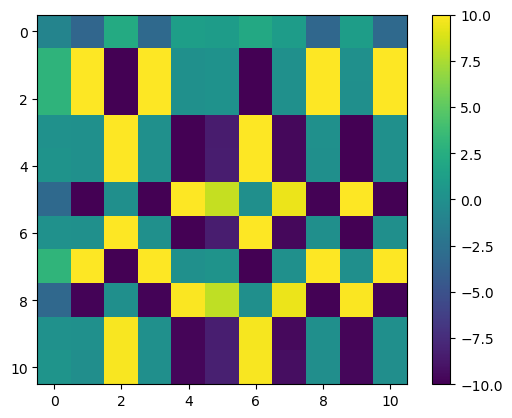

In [26]:
plt.imshow(psro.matrix)
plt.colorbar()

In [24]:
psro.matrix

[[-0.982,
  -3.424,
  2.226,
  -3.176,
  1.174,
  1.09,
  2.088,
  1.088,
  -3.282,
  1.148,
  -3.166],
 [2.998, 10.0, -10.0, 9.96, 0.0, 0.2, -10.0, 0.07, 9.996, 0.0, 9.998],
 [3.024,
  9.994,
  -9.996,
  9.978,
  0.0,
  0.206,
  -9.986,
  0.074,
  9.978,
  -0.002,
  9.992],
 [0.096, 0.0, 10.0, 0.01, -10.0, -8.51, 9.998, -9.59, 0.0, -9.994, 0.002],
 [0.302, 0.0, 10.0, 0.006, -10.0, -8.426, 10.0, -9.582, -0.002, -9.996, 0.002],
 [-3.168,
  -9.926,
  -0.004,
  -9.928,
  9.924,
  8.222,
  -0.014,
  9.414,
  -9.916,
  9.924,
  -9.95],
 [0.128,
  0.01,
  9.996,
  0.014,
  -9.988,
  -8.39,
  9.994,
  -9.58,
  -0.004,
  -9.98,
  -0.002],
 [3.05, 9.998, -9.998, 9.958, 0.0, 0.242, -9.994, 0.056, 9.994, -0.01, 9.992],
 [-3.228,
  -9.824,
  -0.008,
  -9.806,
  9.852,
  8.104,
  -0.008,
  9.378,
  -9.852,
  9.862,
  -9.828],
 [0.144, 0.0, 9.8, 0.02, -9.752, -8.346, 9.76, -9.47, -0.012, -9.754, -0.004],
 [0.35,
  -0.124,
  9.804,
  -0.062,
  -9.682,
  -8.238,
  9.782,
  -9.228,
  -0.124,
  -9.672,


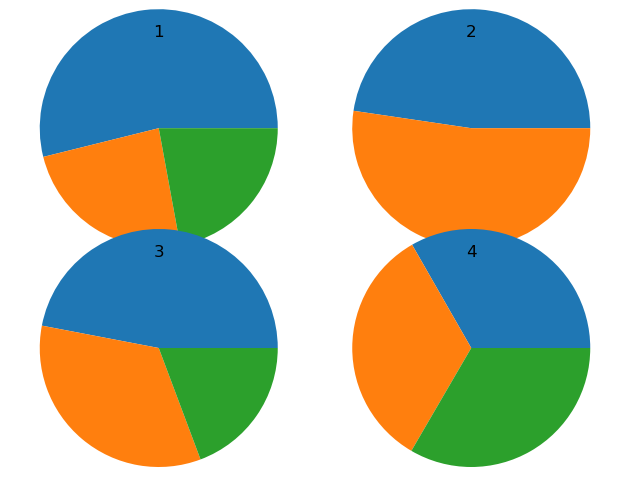

In [29]:
plt.subplot(2, 2, 1)
plt.pie([0.5388, 0.2401, 0.2211])
plt.ylim(0, 0.7)
plt.title('1')
plt.subplot(2, 2, 2)
plt.pie([4.7664e-01, 5.2336e-01, 7.2774e-06])
plt.ylim(0, 0.7)
plt.title('2')
plt.subplot(2, 2, 3)
plt.pie([0.4699, 0.3372, 0.1929])
plt.ylim(0, 0.7)
plt.title('3')
plt.subplot(2, 2, 4)
plt.pie([0.3328, 0.3333, 0.3339])
plt.ylim(0, 0.7)
plt.title('4')
plt.tight_layout()

In [15]:
psro.matrix, psro.prob

([[-0.982,
   -3.424,
   2.226,
   -3.176,
   1.174,
   1.09,
   2.088,
   1.088,
   -3.282,
   1.148,
   -3.166],
  [2.998, 10.0, -10.0, 9.96, 0.0, 0.2, -10.0, 0.07, 9.996, 0.0, 9.998],
  [3.024,
   9.994,
   -9.996,
   9.978,
   0.0,
   0.206,
   -9.986,
   0.074,
   9.978,
   -0.002,
   9.992],
  [0.096, 0.0, 10.0, 0.01, -10.0, -8.51, 9.998, -9.59, 0.0, -9.994, 0.002],
  [0.302,
   0.0,
   10.0,
   0.006,
   -10.0,
   -8.426,
   10.0,
   -9.582,
   -0.002,
   -9.996,
   0.002],
  [-3.168,
   -9.926,
   -0.004,
   -9.928,
   9.924,
   8.222,
   -0.014,
   9.414,
   -9.916,
   9.924,
   -9.95],
  [0.128,
   0.01,
   9.996,
   0.014,
   -9.988,
   -8.39,
   9.994,
   -9.58,
   -0.004,
   -9.98,
   -0.002],
  [3.05, 9.998, -9.998, 9.958, 0.0, 0.242, -9.994, 0.056, 9.994, -0.01, 9.992],
  [-3.228,
   -9.824,
   -0.008,
   -9.806,
   9.852,
   8.104,
   -0.008,
   9.378,
   -9.852,
   9.862,
   -9.828],
  [0.144, 0.0, 9.8, 0.02, -9.752, -8.346, 9.76, -9.47, -0.012, -9.754, -0.004],
  [0.3